# Plan

1) Setup
2) Load Data
3) Data wrangling
4) EDA
5) Build model/ Make predictions
6) Calculate accuracy
7) Conclusions

___

# 1 | Setup

In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import numpy as np
import os

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)
color_pal = ["#F8766D", "#D39200", "#93AA00", "#00BA38", "#00C19F", "#00B9E3", "#619CFF", "#DB72FB"]

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "Forecasting_Retail_Australia"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
pd.set_option('display.max_columns', None)
# pd.set_option('display.float_format', '{:.2%}'.format)

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error, mean_absolute_error
plt.style.use('fivethirtyeight')

___

# 2 | Load Data

In [2]:
# Get Actuals from Jan 2017 to December 2022
df = pd.read_csv('Actuals_Retail_Australia_2017To2022.csv', 
                 skipfooter=1, 
                 parse_dates=['Date'], 
                 dayfirst=True, 
                 index_col=[0], 
                 engine='python')

df.rename(columns = {'Sum of Quantity' : 'Quantity'}, inplace=True)

In [4]:
# Select only B500BT17
product_ = 'B500BT17'

df = df[df["Item"].values == product_]

____

# 3 | Data Wrangling

In [6]:
df['Year'] = df.index.year 
df['Month'] = df.index.month 
df['Day'] = 1

from datetime import datetime, timedelta
df['inserted_date'] = pd.to_datetime(df[['Year', 'Month', 'Day']])
df.head()

,Location,Item,Quantity,Year,Month,Day,inserted_date
Date,,,,,,,
2017-01-01,Aesop Carindale,B500BT17,1.0,2017,1,1,2017-01-01
2017-01-01,Aesop Chadstone,B500BT17,2.0,2017,1,1,2017-01-01
2017-01-01,Aesop Claremont Quarter,B500BT17,1.0,2017,1,1,2017-01-01
2017-01-01,Aesop Doncaster,B500BT17,3.0,2017,1,1,2017-01-01
2017-01-01,Aesop Emporium I,B500BT17,2.0,2017,1,1,2017-01-01


#### Group by month-year

In [7]:
result_g = df.groupby([df.inserted_date]).agg({'Quantity':sum})

result_gs = result_g[result_g.index < '2022-08-01']
result_gs.head()

,Quantity
inserted_date,
2017-01-01,1952.0
2017-02-01,1898.0
2017-03-01,2052.0
2017-04-01,2016.0
2017-05-01,1977.0


____

# 4 | EDA

#### Rolling Average

C:\Users\KEVAN~1.TAM\AppData\Local\Temp/ipykernel_293052/3744121521.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result_gs["rolling_avg"] = result_gs["Quantity"].rolling(window=12).mean() #window size 12 denotes 12 months, giving rolling mean at yearly level
C:\Users\KEVAN~1.TAM\AppData\Local\Temp/ipykernel_293052/3744121521.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result_gs["rolling_std"] = result_gs["Quantity"].rolling(window=12).std()


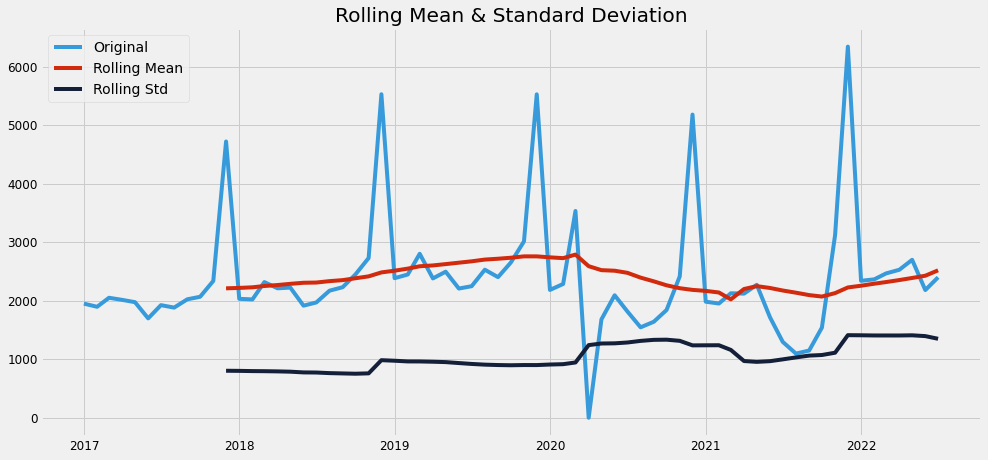

In [9]:
# _ = result.plot(style='.', figsize=(15,5), color=color_pal[0], title='Quantity')

#Determine rolling statistics
result_gs["rolling_avg"] = result_gs["Quantity"].rolling(window=12).mean() #window size 12 denotes 12 months, giving rolling mean at yearly level
result_gs["rolling_std"] = result_gs["Quantity"].rolling(window=12).std()

#Plot rolling statistics
plt.figure(figsize=(15,7))
plt.plot(result_gs["Quantity"], color='#379BDB', label='Original')
plt.plot(result_gs["rolling_avg"], color='#D22A0D', label='Rolling Mean')
plt.plot(result_gs["rolling_std"], color='#142039', label='Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')
plt.show(block=False)

### Time Series Decomposition
Decompose the example time series into trend, seasonal, and residual components.

- https://towardsdatascience.com/time-series-decomposition-and-statsmodels-parameters-69e54d035453

In [10]:
pd.options.display.max_columns = 99
plt.rcParams['figure.figsize'] = [10, 10]

In [11]:
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

In [12]:
period_set = 12
period_set

12

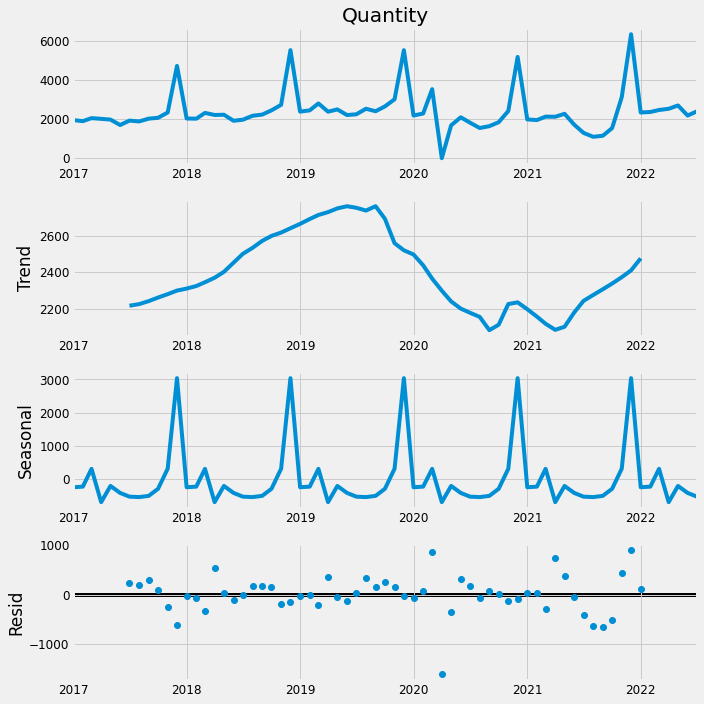

In [13]:
# https://towardsdatascience.com/time-series-decomposition-and-statsmodels-parameters-69e54d035453
fig = seasonal_decompose(result_gs['Quantity'], model='additive', period=period_set).plot()

Note:
- We can clearly see that the trend goes up from 17 to 20, then goes down due to COVID 19 and finally goes up again from 21.
- We can also say that sales increase at the end of each year.

There is clearly yearly seasonality and a non-stationary, upward trend. We can run a Dickey-Fuller test to examine the stationarity.

#### Dickey–Fuller test 

In [14]:
dftest = adfuller(result_gs['Quantity'], autolag='AIC')
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
dfoutput

Test Statistic                 -1.021772
p-value                         0.745241
#Lags Used                     11.000000
Number of Observations Used    55.000000
Critical Value (1%)            -3.555273
Critical Value (5%)            -2.915731
Critical Value (10%)           -2.595670
dtype: float64

https://en.wikipedia.org/wiki/Dickey%E2%80%93Fuller_test

In statistics, the Dickey–Fuller test tests the null hypothesis that a unit root is present in an autoregressive (AR)
time series model. The alternative hypothesis is different depending on which version of the test is used, but is usually stationarity or trend-stationarity. The test is named after the statisticians David Dickey and Wayne Fuller, who developed it in 1979.

To know more about the time series stationarity, we can perform the ADfuller test, a test based on hypothesis, where if the p-value is less than 0.05, then we can consider the time series is stationary, and if the P-value is greater than 0.05, then the time series is non-stationary.

In our case, p-value is less than 0.05 and considers that time series is stationary. We know that Covid was an unexpected event that happenned, however, we can clearly see that slope was upward before covid and after covid, so we will try to analyse only after covid.

<!-- ### Exclude Covid Period
Next we want to remove the Covid Period because we judge that this caused a unsual pattern of downward slope which is not representative of the situation of Aesop.

\
Minimize covid: https://stats.stackexchange.com/questions/500382/how-to-deal-with-historic-data-that-is-impacted-by-covid-19-time-series-foreca -->

In [15]:
# result2 = result[result.index > '2020-12-31']
# fig = seasonal_decompose(result2['Quantity'], model='additive', period=period_set).plot()
# dftest2 = adfuller(result2['Quantity'], autolag='AIC')
# dfoutput = pd.Series(dftest2[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
# for key,value in dftest[4].items():
#     dfoutput['Critical Value (%s)'%key] = value
# dfoutput

In [16]:
# !pip install --trusted-host pypi.org --trusted-host files.pythonhosted.org pip install pmdarima

____

# 5 | Build Model using SARIMA

About Sarima
- https://analyticsindiamag.com/complete-guide-to-sarimax-in-python-for-time-series-modeling/
- https://www.statsmodels.org/dev/generated/statsmodels.tsa.statespace.sarimax.SARIMAX.html
- https://towardsdatascience.com/time-series-forecasting-with-arima-sarima-and-sarimax-ee61099e78f6

In [17]:
import pmdarima as pm

# Seasonal - fit stepwise auto-ARIMA
SARIMA_model = pm.auto_arima(result_gs["Quantity"], start_p=1, start_q=1,
                         test='adf',
                         max_p=3, max_q=3, 
                         m=12, #12 is the frequncy of the cycle
                         start_P=0, 
                         seasonal=True, #set to seasonal
                         d=None, 
                         D=1, #order of the seasonal differencing
                         trace=False,
                         error_action='ignore',  
                         suppress_warnings=True, 
                         stepwise=True)

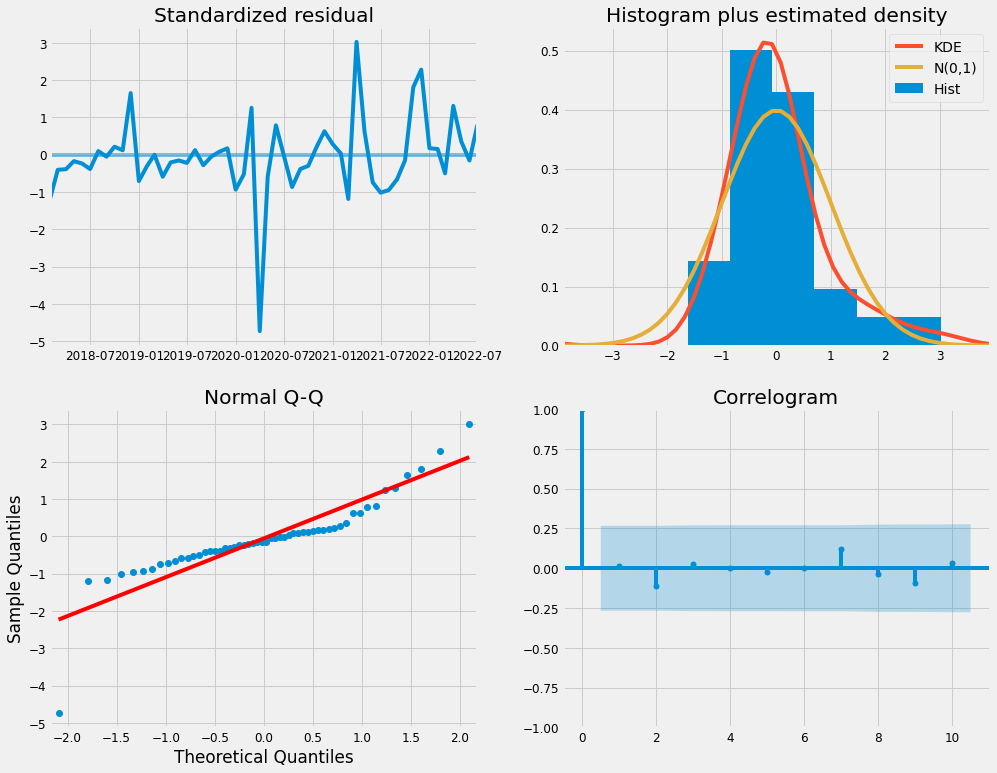

In [18]:
SARIMA_model.plot_diagnostics(figsize=(15,12))
plt.show()

1) Standardized residual
The Standardized residual is consistent across the graph, meaning that the data is closer to being stationary.

2) Histogram plus KDE estimate
The KDE curve is similar to the normal distribution.

3) Normal Q-Q
The data points are clustered close to the line.

4) Correlogram (ACF plot)
The light blue area is the confidence band, and if values fall outside of this then they are statistically significant. We want all values inside this area. All the points fall within the 95% confidence interval.

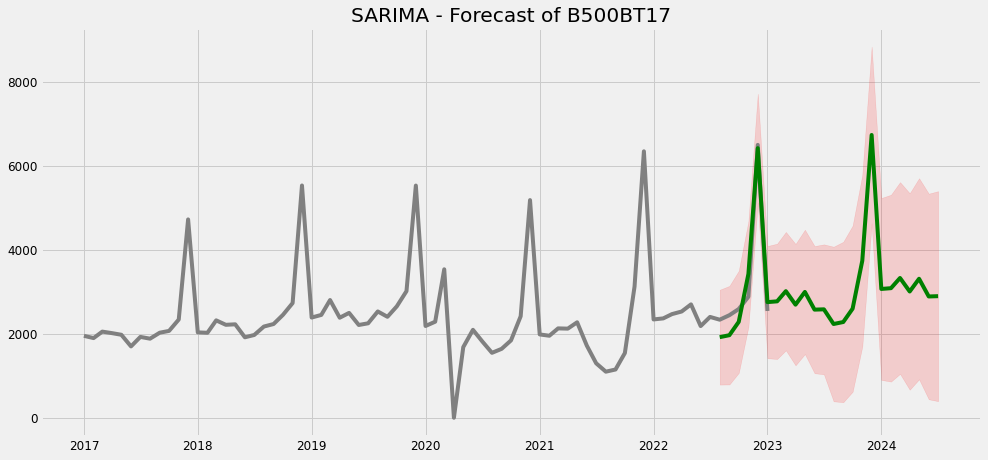

In [19]:
def forecast(SARIMA_model, periods=24):
    # Forecast
    n_periods = periods
    fitted, confint = SARIMA_model.predict(n_periods=n_periods, return_conf_int=True)
    index_of_fc = pd.date_range(result_gs.index[-1] + pd.DateOffset(months=1), periods = n_periods, freq='MS')

    # make series for plotting purpose
    fitted_series = pd.Series(fitted, index=index_of_fc)
    lower_series = pd.Series(confint[:, 0], index=index_of_fc)
    upper_series = pd.Series(confint[:, 1], index=index_of_fc)

    # Plot
    plt.figure(figsize=(15,7))
    plt.plot(result_g["Quantity"], color='grey')
    plt.plot(fitted_series, color='green')
    plt.fill_between(lower_series.index, 
                    lower_series, 
                    upper_series, 
                    color='r', alpha=.15)

    plt.title(f"SARIMA - Forecast of {product_}")
    plt.show()

forecast(SARIMA_model)

In [20]:
fitted, confint = SARIMA_model.predict(n_periods=6, return_conf_int=True)

____

# 6 | Calculate forecast accuracy

#### Calculate the current forecast accuracy

In [21]:
fm_forecast = [2586, 2250, 2646, 4080, 6114, 2196][3:]
actual   = result_g.Quantity.tail(3)

APE_2 = []
  
# Iterate over the list values
for day in range(len(fm_forecast)):
  
    # Calculate percentage error
    per_err = (actual[day] - fm_forecast[day]) / actual[day]
  
    # Take absolute value of
    # the percentage error (APE)
    per_err = abs(per_err)
  
    # Append it to the APE list
    APE_2.append(per_err)
  
# Calculate MAPE
MAPE = sum(APE_2)/len(APE_2)
  
# Print the MAPE value and percentage
print(f'''
MAPE   : { round(MAPE, 2) }
MAPE % : { round(MAPE*100, 2) } %
''')


MAPE   : 0.2
MAPE % : 20.37 %



#### Calculate the new forecast accuracy

In [22]:
# Define the dataset as python lists
actual   = result_g.Quantity.tail(3)
forecast = fitted[3:]
  
# Consider a list APE to store the
# APE value for each of the records in dataset
APE = []
  
# Iterate over the list values
for day in range(len(actual)):
  
    # Calculate percentage error
    per_err = (actual[day] - forecast[day]) / actual[day]
  
    # Take absolute value of
    # the percentage error (APE)
    per_err = abs(per_err)
  
    # Append it to the APE list
    APE.append(per_err)
  
# Calculate the MAPE
MAPE = sum(APE)/len(APE)
  
# Print the MAPE value and percentage
print(f'''
MAPE   : { round(MAPE, 2) }
MAPE % : { round(MAPE*100, 2) } %
''')


MAPE   : 0.09
MAPE % : 9.44 %



____

# 7 | Conclusion:
Our goal was to analyse the dataset to know how it was built. This helped us to choose and to build the model that allowed us to improve the baseline by 53%. 

#### Key Takeaways:
- Time series is non-stationary and there is a seasonality effect.
- Covid 19 happened and had obviously an impact in the sales. We might consider to do researches in order to find a way to work limit the impact of Covid 19 in our final results.
- Use of Sarima which is a statistic method which takes into consideration the seasonality of our time series to the calculation of our forecasts.
- By using a simple stats method we improved by 53 % our baseline from 20.37 % to 9.44 %.
- New Methods/ Algorithms should be tested (Facebook Prophet/ XG boost) to improve the baseline established by SARIMA.

# END.

#### References 
- https://www.kaggle.com/code/robikscube/tutorial-time-series-forecasting-with-xgboost
    
- import xgboost as xgb
- from xgboost import plot_importance, plot_tree